In [48]:
import itertools
from pathlib import Path

import numpy as np
import torch

from zsl_config import ZSL_DIR_ANALYSIS
from zsl_utils.mpl import *

In [49]:
MODEL_CLASS = 'olmo'
DATASET = 'c4_en_val'
ANALYSIS_NAME = 'per_token_change_in_loss-dt=1'

RUNS = [
        '1028-rmsnorm-14m',
        '1028-rmsnorm-37m',
        '1028-rmsnorm-78m',
        '1028-rmsnorm-144m',
        '1028-rmsnorm-285m',
        '1028-rmsnorm-472m',
    ]

VERBOSE = True
OVERWRITE = False

OUT_DIR = ZSL_DIR_ANALYSIS / ANALYSIS_NAME
assert OUT_DIR.exists()

FIG_DIR = Path.cwd() / "fig"
FIG_DIR.mkdir(exist_ok=True)

# Visualization

In [50]:
def load_losses(run, step, train_batch_step, post_init, split, device='cpu', seq_len=1024):
    assert post_init in ['post', 'init']
    assert split in ['train', f'eval-{DATASET}']
    f = OUT_DIR / run / f"train-batch={train_batch_step}/{post_init}/{split}/step{step}.pt"
    losses = torch.load(f, map_location=device, weights_only=True)

    if len(losses.shape) == 1:
        losses = losses.view(-1, seq_len-1)

    return losses

def get_steps(run, train_batch_step, post_init, split):
    d = OUT_DIR / run / f"train-batch={train_batch_step}/{post_init}/{split}"
    steps = [int(f.stem.split('step')[1]) for f in d.glob('step*.pt')]
    steps = list(sorted(steps))
    return steps

def get_train_batch_steps(run):
    d = OUT_DIR / run
    train_batch_steps = sorted([int(f.name.split('=')[1]) for f in d.glob('train-batch=*')])
    return train_batch_steps

if VERBOSE:
    run = RUNS[0]
    split = 'train'
    post_init = 'init'
    train_batch_steps = get_train_batch_steps(run)
    steps = get_steps(run, train_batch_steps[0], post_init, split)
    losses = load_losses(run, steps[0], train_batch_steps[0], post_init, split)
    print(f"run: {run}")
    print(f"train_batch_steps: {train_batch_steps}")
    print(f"steps: {steps}")
    print(f"loss: {losses.mean().item():.2f} (shape {losses.shape})")
    del run, split, post_init, train_batch_steps, steps, losses


run: 1028-rmsnorm-14m
train_batch_steps: [262144, 262145, 262146, 262147, 262148]
steps: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
loss: 11.18 (shape torch.Size([512, 1023]))


## Loss
Sanity check that loss values are reasonable for one-step

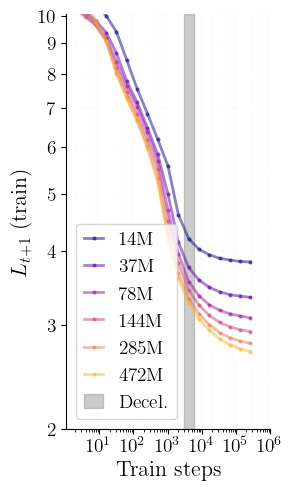

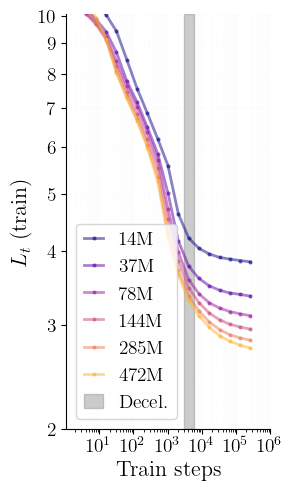

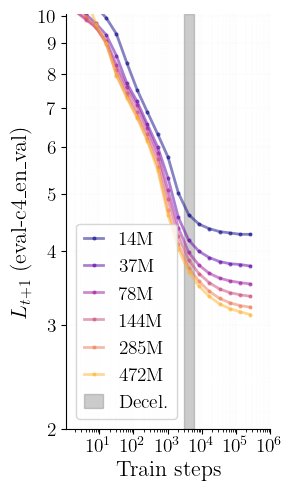

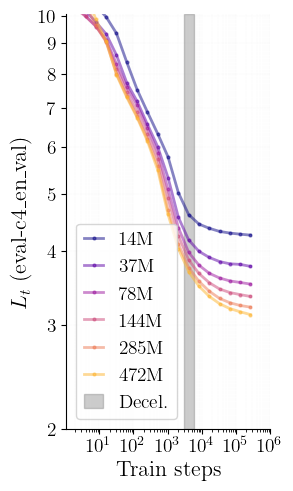

In [51]:
TRAIN_BATCH_STEP = 262144
splits = ['train', f'eval-{DATASET}']
post_inits = ['post', 'init']

def plot_data(ax, run, model_size, train_batch_step, post_init, split):
    steps = get_steps(run, train_batch_step, post_init, split)
    color = get_color(RUNS.index(run), vmax=len(RUNS))

    losses_avg = []
    for step in steps:
        print(f"Loading {run} step {step}", end='\r')
        losses = load_losses(run, step, train_batch_step, post_init, split)
        avg = losses.mean().item()
        losses_avg += [avg]
    
    ax.plot(steps, losses_avg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    return ax

def format_plot(fig, ax, ylabel=None):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ylabel = ylabel or '$L$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('log')
    ax.yaxis.set_ticks(list(range(2,11)))
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_ylim(2, 10.1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14, loc='lower left')

    fig.set_size_inches(*FIGSIZE_NARROW)
    plt.close(fig)
    fig.subplots_adjust(left=0.22, right=0.9, top=0.95, bottom=0.12)
    return fig, ax

for split, post_init in itertools.product(splits, post_inits):
    fig, ax = plt.subplots()
    for i, run in enumerate(RUNS):
        model_size = run.split('-')[-1].replace('m', 'M')
        ax = plot_data(ax, run, model_size, TRAIN_BATCH_STEP, post_init, split)
    
    ylabel = "$L_{t}$" if post_init == 'init' else "$L_{t+1}$" 
    ylabel += f" ({split})"
    fig, ax = format_plot(fig, ax, ylabel)
    display(fig)

## Destructive interference

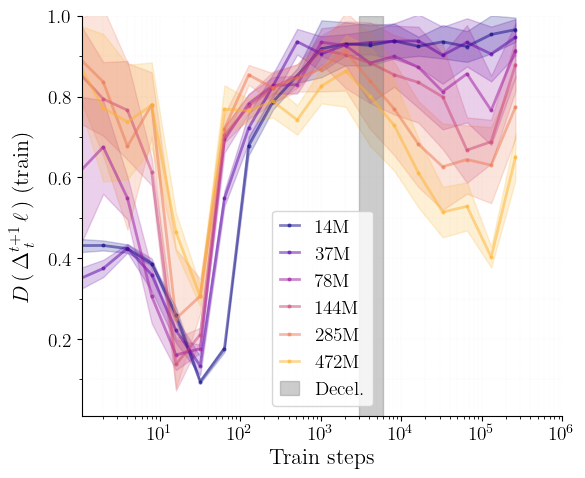

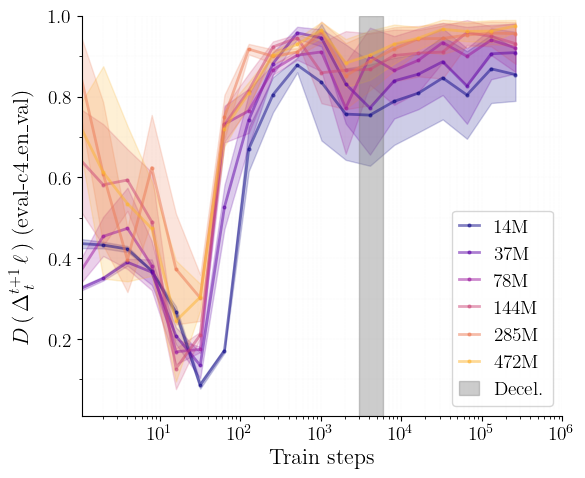

In [52]:
splits = ['train', f'eval-{DATASET}']

get_fp = lambda n: FIG_DIR / f'loss_intrf_dt=1/{n}'


def plot_data(ax, run, model_size, split):
    train_batch_steps = get_train_batch_steps(run)
    steps = get_steps(run, train_batch_steps[0], 'init', split)    
    all_ldis = []
    for train_batch_step in train_batch_steps:
        _steps = get_steps(run, train_batch_step, 'init', split)
        assert _steps == steps, f"steps {steps} != {_steps}"
        color = get_color(RUNS.index(run), vmax=len(RUNS))

        ldis = []
        for step in steps:
            print(f"Loading {run} step {step}", end='\r')
            losses1 = load_losses(run, step, train_batch_step, 'init', split)
            losses2 = load_losses(run, step, train_batch_step, 'post', split)
            dl = losses2 - losses1
            ldis.append(1-dl.sum().abs().item()/dl.abs().sum().item())
        ldis = np.array(ldis)
        all_ldis.append(ldis)
    ldis_avg = np.mean(all_ldis, axis=0)
    ldis_std = np.std(all_ldis, axis=0)
    ldis_hi = ldis_avg + ldis_std
    ldis_lo = ldis_avg - ldis_std
    ax.plot(steps, ldis_avg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    ax.fill_between(steps, ldis_lo, ldis_hi, alpha=0.2, color=color)
    return ax

def format_plot(fig, ax, ylabel=None):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0.01, 1)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax

for split in splits:
    fig_path = get_fp(f'D__{split}.pdf')
    fig_path.parent.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots()
    for i, run in enumerate(RUNS):
        model_size = run.split('-')[-1].replace('m', 'M')
        ax = plot_data(ax, run, model_size, split)
    
    ylabel = '$D\,(\,\Delta_{\:t}^{t+1} \, \ell\,)$'
    ylabel += f" ({split})"
    fig, ax = format_plot(fig, ax, ylabel)
    save_figure(fig, fig_path, save_json=False, save_png=False)
    display(fig)

## Average Magnitude

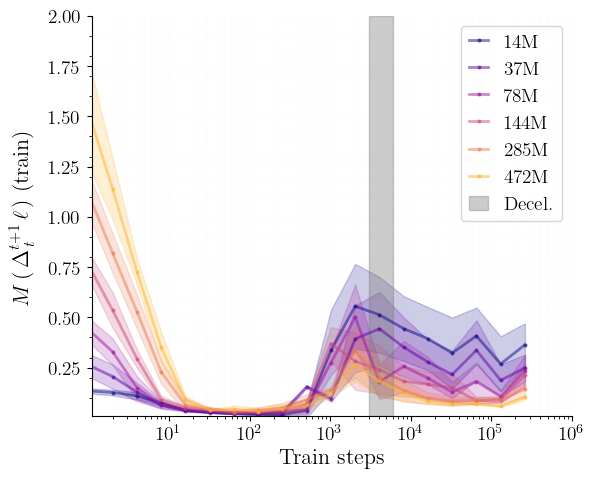

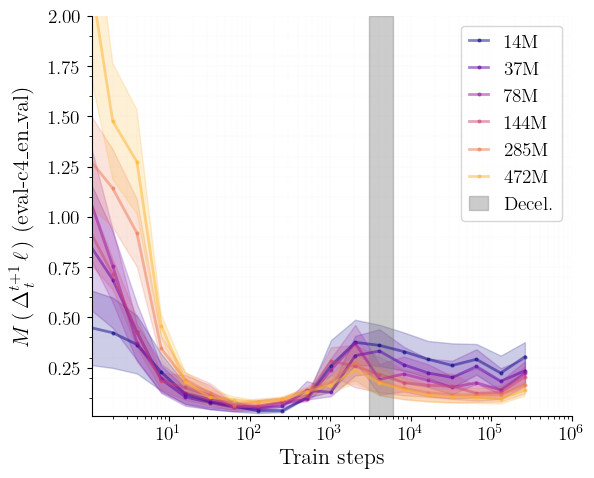

In [53]:
splits = ['train', f'eval-{DATASET}']

def plot_data(ax, run, model_size, split):
    train_batch_steps = get_train_batch_steps(run)
    steps = get_steps(run, train_batch_steps[0], 'init', split)    
    all_mags = []
    for train_batch_step in train_batch_steps:
        _steps = get_steps(run, train_batch_step, 'init', split)
        assert _steps == steps, f"steps {steps} != {_steps}"
        color = get_color(RUNS.index(run), vmax=len(RUNS))

        mags = []
        for step in steps:
            print(f"Loading {run} step {step}", end='\r')
            losses1 = load_losses(run, step, train_batch_step, 'init', split)
            losses2 = load_losses(run, step, train_batch_step, 'post', split)
            dl = losses2 - losses1
            mags.append(dl.abs().mean())
        mags = np.array(mags)
        all_mags.append(mags)
    mags_avg = np.mean(all_mags, axis=0)
    mags_std = np.std(all_mags, axis=0)
    mags_hi = mags_avg + mags_std
    mags_lo = mags_avg - mags_std
    ax.plot(steps, mags_avg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    ax.fill_between(steps, mags_lo, mags_hi, alpha=0.2, color=color)
    return ax

def format_plot(fig, ax, ylabel=None):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0.01, 2)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=14)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax

for split in splits:
    fig_path = get_fp(f'M__{split}.pdf')
    fig_path.parent.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots()
    for i, run in enumerate(RUNS):
        model_size = run.split('-')[-1].replace('m', 'M')
        ax = plot_data(ax, run, model_size, split)
    
    ylabel = '$M\,(\,\Delta_{\:t}^{t+1} \, \ell\,)$'
    ylabel += f" ({split})"
    fig, ax = format_plot(fig, ax, ylabel)
    save_figure(fig, fig_path, save_json=False, save_png=False)
    display(fig)

## Overall Loss Improvement (LI)

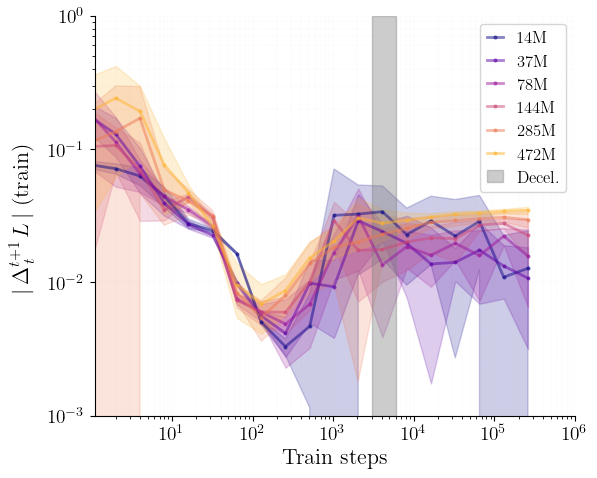

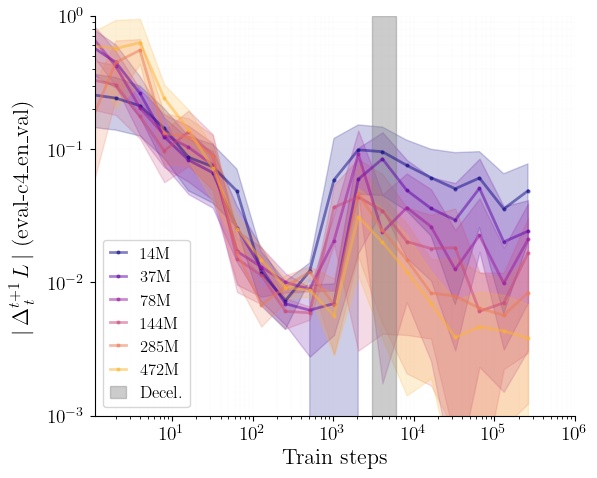

In [54]:
splits = ['train', f'eval-{DATASET}']

def plot_data(ax, run, model_size, split):
    train_batch_steps = get_train_batch_steps(run)
    steps = get_steps(run, train_batch_steps[0], 'init', split)    
    all_mags = []
    for train_batch_step in train_batch_steps:
        _steps = get_steps(run, train_batch_step, 'init', split)
        assert _steps == steps, f"steps {steps} != {_steps}"
        color = get_color(RUNS.index(run), vmax=len(RUNS))

        mags = []
        for step in steps:
            print(f"Loading {run} step {step}", end='\r')
            losses1 = load_losses(run, step, train_batch_step, 'init', split)
            losses2 = load_losses(run, step, train_batch_step, 'post', split)
            dl = losses2 - losses1
            mags.append(dl.mean().abs())
        mags = np.array(mags)
        all_mags.append(mags)
    mags_avg = np.mean(all_mags, axis=0)
    mags_std = np.std(all_mags, axis=0)
    mags_hi = mags_avg + mags_std
    mags_lo = mags_avg - mags_std
    ax.plot(steps, mags_avg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    ax.fill_between(steps, mags_lo, mags_hi, alpha=0.2, color=color)
    return ax

def format_plot(fig, ax, ylabel=None):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ax.set_ylabel(ylabel)
    ax.set_yscale('log')
    ax.set_ylim(0.001, 1)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=12)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax

for split in splits:
    fig_path = get_fp(f'|ΔL|__{split}__log.pdf')
    fig_path.parent.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots()
    for i, run in enumerate(RUNS):
        model_size = run.split('-')[-1].replace('m', 'M')
        ax = plot_data(ax, run, model_size, split)
    
    ylabel = '$|\,\Delta_{\:t}^{t+1} \, L\,|$'
    ylabel += f" ({split})"
    fig, ax = format_plot(fig, ax, ylabel)
    save_figure(fig, fig_path, save_json=False, save_png=False)
    display(fig)

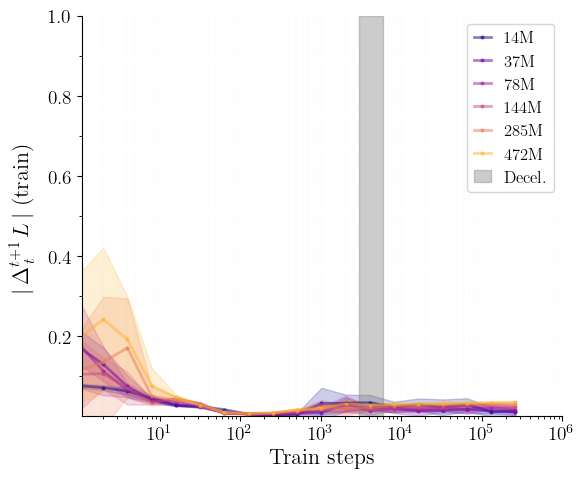

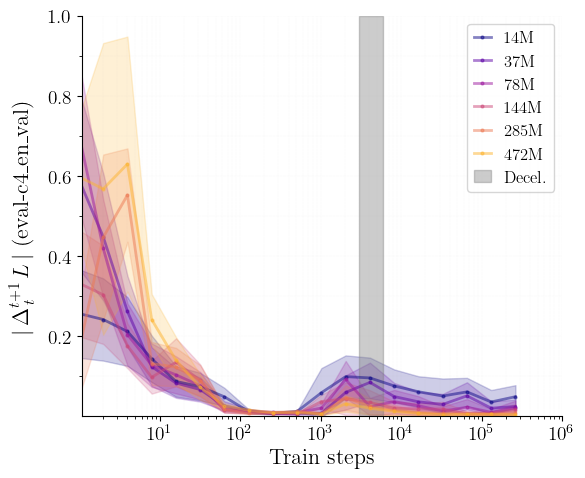

In [55]:
splits = ['train', f'eval-{DATASET}']

def plot_data(ax, run, model_size, split):
    train_batch_steps = get_train_batch_steps(run)
    steps = get_steps(run, train_batch_steps[0], 'init', split)    
    all_mags = []
    for train_batch_step in train_batch_steps:
        _steps = get_steps(run, train_batch_step, 'init', split)
        assert _steps == steps, f"steps {steps} != {_steps}"
        color = get_color(RUNS.index(run), vmax=len(RUNS))

        mags = []
        for step in steps:
            print(f"Loading {run} step {step}", end='\r')
            losses1 = load_losses(run, step, train_batch_step, 'init', split)
            losses2 = load_losses(run, step, train_batch_step, 'post', split)
            dl = losses2 - losses1
            mags.append(dl.mean().abs())
        mags = np.array(mags)
        all_mags.append(mags)
    mags_avg = np.mean(all_mags, axis=0)
    mags_std = np.std(all_mags, axis=0)
    mags_hi = mags_avg + mags_std
    mags_lo = mags_avg - mags_std
    ax.plot(steps, mags_avg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=model_size)
    ax.fill_between(steps, mags_lo, mags_hi, alpha=0.2, color=color)
    return ax

def format_plot(fig, ax, ylabel=None):
    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    # HACK: make sure log scale ticks/grids are visible
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))

    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0.001, 1)
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))
    ax.yaxis.labelpad = 10

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    # remove decel if already exists
    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    ax.legend(handlelength=1, fontsize=12)

    fig.set_size_inches(*FIGSIZE_MED)
    plt.close(fig)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax

for split in splits:
    fig_path = get_fp(f'|ΔL|__{split}.pdf')
    fig_path.parent.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots()
    for i, run in enumerate(RUNS):
        model_size = run.split('-')[-1].replace('m', 'M')
        ax = plot_data(ax, run, model_size, split)
    
    ylabel = '$|\,\Delta_{\:t}^{t+1} \, L\,|$'
    ylabel += f" ({split})"
    fig, ax = format_plot(fig, ax, ylabel)
    save_figure(fig, fig_path, save_json=False, save_png=False)
    display(fig)

## Training Trajectories in DI/MA/LD

/tmp/ipykernel_2878086/1270705170.py:71: RuntimeWarning: divide by zero encountered in log2
  Z = np.log2((1-X)*Y).clip(min=-7, max=1)


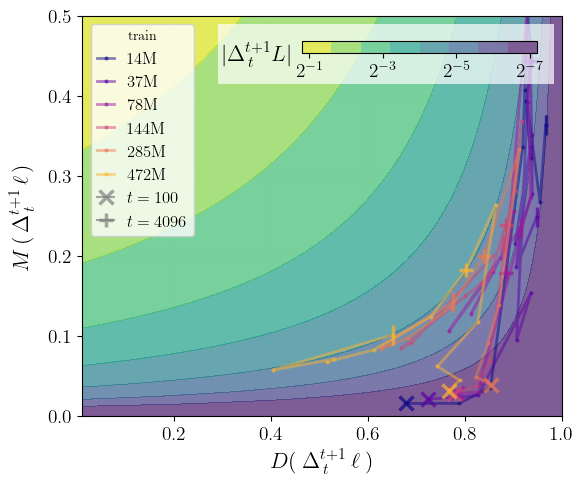

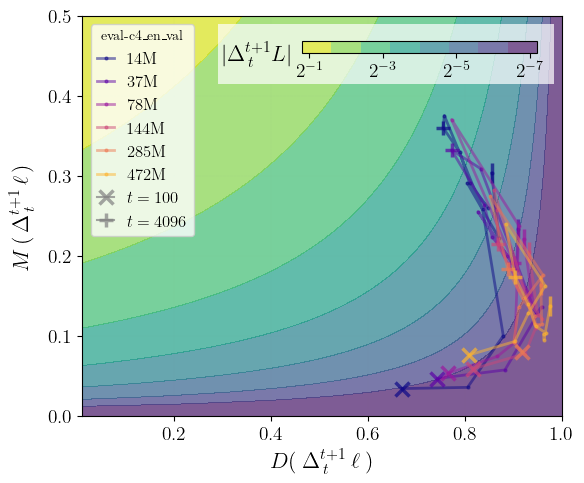

In [56]:
min_step=100
def plot_data(ax, run, model_size, decel_span=[3000,6000]):
    train_batch_steps = get_train_batch_steps(run)
    steps = get_steps(run, train_batch_steps[0], 'init', split)    
    steps = [step for step in steps if step >= min_step]
    color = get_color(RUNS.index(run), vmax=len(RUNS))
    all_ldis = []
    all_mags = []
    all_ldi_decels = []
    all_mag_decels = []
    for train_batch_step in train_batch_steps:
        _steps = get_steps(run, train_batch_step, 'init', split)
        _steps = [step for step in _steps if step >= min_step]
        assert _steps == steps, f"steps {steps} != {_steps}"
        color = get_color(RUNS.index(run), vmax=len(RUNS))
        
        ldis = []
        mags = []
        ldi_decel = []
        mag_decel = []
        for step in steps:
            print(f"Loading {run} step {step}", end='\r')
            losses1 = load_losses(run, step, train_batch_step, 'init', split)
            losses2 = load_losses(run, step, train_batch_step, 'post', split)
            dl = losses2 - losses1
            ldis.append(1-dl.sum().abs().item()/dl.abs().sum().item())
            mags.append(dl.abs().mean().item()) 
            if step < decel_span[1] and step > decel_span[0]:
                ldi_decel += ldis[-1:]
                mag_decel += mags[-1:]  
        
        ldis = np.array(ldis)
        all_ldis.append(ldis)
        mags = np.array(mags)
        all_mags.append(mags)

        ldi_decel = np.array(ldi_decel)
        all_ldi_decels.append(ldi_decel)
        mag_decel = np.array(mag_decel)
        all_mag_decels.append(mag_decel)  

    ldis_avg = np.mean(all_ldis, axis=0)
    mags_avg = np.mean(all_mags, axis=0)
    ldi_decel = np.mean(all_ldi_decels, axis=0)
    mag_decel = np.mean(all_mag_decels, axis=0)

    ax.plot(ldis_avg, mags_avg, alpha=0.5, color=color, linewidth=2, marker='o', ms=2,  label=model_size)
    ax.plot(ldis_avg[:1], mags_avg[:1], linewidth=1.5, color=color, alpha=0.7, marker='x', ms=10, markeredgewidth=2.5)
    ax.plot(ldis_avg[-1:], mags_avg[-1:], linewidth=1.5, color=color, alpha=0.7, marker='|', ms=15, markeredgewidth=2.5)
    ax.plot(ldi_decel, mag_decel, linewidth=1.5, color=color, alpha=0.7, marker='+', ms=10, markeredgewidth=2.5)
    return ax


def format_plot(fig, ax, split):
    xlabel = '$D(\:\Delta_{\:t}^{t+1} \: \ell\:)$'
    ax.set_xlabel(xlabel)
    ax.set_xscale('linear')
    ax.set_xlim(0.01, 1)

    ylabel = '$M\,(\,\Delta_{\:t}^{t+1} \, \ell\,)$'
    ax.set_ylabel(ylabel)
    ax.set_yscale('linear')
    ax.set_ylim(0, 0.5)
    ax.yaxis.labelpad = 10

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    X = np.linspace(xmin, xmax, 1000)
    Y = np.linspace(0, ymax, 100)
    X, Y = np.meshgrid(X, Y)
    Z = np.log2((1-X)*Y).clip(min=-7, max=1)
    heatmap = ax.contourf(X, Y, Z, levels=8, cmap='viridis', alpha=0.7)
    cbbox = inset_axes(ax, '70%', '15%', loc = 'upper right')
    cbbox.set_facecolor([1,1,1,0.7])
    # remove all axes and ticks from cbbox while keeping facecolor
    # cbbox.axis('off') will remove facecolor and is not an option
    # Remove all axes and ticks from cbbox while keeping facecolor
    cbbox.spines['top'].set_visible(False)
    cbbox.spines['bottom'].set_visible(False)
    cbbox.spines['left'].set_visible(False)
    cbbox.spines['right'].set_visible(False)
    cbbox.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Add colorbar to cbbox
    cbaxes = inset_axes(cbbox, '70%', '20%', loc = 1, borderpad=1.0)
    cb = fig.colorbar(heatmap, cax=cbaxes,
                    ticks=[-7, -5, -3, -1, 1],
                    format=mtick.FuncFormatter(lambda x, _: f'$2^{{{x}}}$'),
                    orientation='horizontal',
                    )
    cb.ax.invert_xaxis()
    cbbox.text(0.12, 0.5, "$|\Delta_{\:t}^{t+1} L|$", ha='center', va='center', rotation='horizontal', fontsize=16)

    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    for line in ax.get_lines():
        if line.get_label() in ['$t=100$', 'Decel.']:
            line.remove()
    ax.plot([], [], linewidth=1.5, color='gray', alpha=0.7, marker='x', ms=10, markeredgewidth=2.5, label=f'$t={min_step}$')
    ax.plot([], [], linewidth=1.5, color='gray', alpha=0.7, marker='+', ms=10, markeredgewidth=2.5, label='$t=4096$')
    ax.legend(handlelength=1, loc='upper left', title=split)

    plt.close(fig)
    fig.set_size_inches(*FIGSIZE_MED)
    fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
    return fig, ax



for split in splits:
    fig_path = get_fp(f'D_vs_M__{split}.pdf')
    fig, ax = plt.subplots()
    for i, run in enumerate(RUNS):
        model_size = run.split('-')[-1].replace('m', 'M')
        ax = plot_data(ax, run, model_size)
    fig, ax = format_plot(fig, ax, split)
    save_figure(fig, fig_path, save_json=False, save_png=False)
    display(fig)